# PROJEKT MODELU KLASYFIKACYJNEGO PRZEWIDYWANIA STANU MIESZKAŃ NA PODSTAWIE #

## Extra Trees Classifier ##

### kwiecień 2025

In [1]:
import pandas as pd
from pycaret.classification import setup, pull, compare_models, plot_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
import pymysql
from sqlalchemy import create_engine
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# tą komórkę uruchom jeżeli bazę danych bierzesz np. z DBeaver, oracle developer itp.

#username = 'root'
#password = '1234'
#host = '127.0.0.1'
#port = 3306  
#database = 'projekt1'
#engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

#df = pd.read_sql("SELECT * FROM saleflats", con=engine)

#engine.dispose()

In [3]:
# tę komórkę uruchom jeśli czerpiesz dane z pliku .csv
df = pd.read_csv('sale_2024_GOOD.csv', sep=',')

In [4]:
df

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,4236969,NaN,10,"Przestronne, jasne mieszkanie Rataje, niski blok",Na sprzedaż mieszkanie położone na III pietrze...,60.40,495000.0,580000.0,654666.67,NaN,...,NaN,"Wielkopolskie, Poznań, Poznań-nowe Miasto, Żeg...",30.0,64.0,4.0,9.0,970218.0,NaN,20900.0,YNwIfRAf_6pTlpT4SzWIFzD3XjSU8KMxGYrRgZJdWOU=
1,4237112,NaN,10,Mieszkanie 3pok/65m2/balkon/Wawer,Na sprzedaż mieszkanie od dewelopera w nowej i...,65.19,889843.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Wawer, Marysin Wawerski",14.0,65.0,14.0,8.0,919022.0,NaN,NaN,rVMBRluLuEIsfQgGWLCI7Jh-FeyVMDlaeq9iV3jfYyE=
2,4237182,NaN,17,"Mieszkanie, ul. Młodopolska",Prezentujemy Państwu na sprzedaż dwupokojowe m...,50.90,340000.0,372500.0,455333.33,NaN,...,NaN,"Śląskie, Gliwice, Sośnica, Ul. Młodopolska",24.0,66.0,1.0,1.0,940105.0,NaN,13074.0,rVMBRluLuEIsfQgGWLCI7Ki_rC3KFy_RnfS0EWfIRU4=
3,4237257,NaN,10,M3 | Dla rodziny | Zieleń | MPK | OKAZJA,Oferujemy funkcjonalne i przestronne mieszkani...,72.00,899000.0,1047500.0,1418000.00,NaN,...,NaN,"Małopolskie, Kraków, Kraków-śródmieście, Prądn...",12.0,61.0,5.0,9.0,951400.0,NaN,NaN,h6Ow6N1Fx0SgynxoxPSS22rEJkU2QT-yp-az_9WBzEQ=
4,4237328,NaN,2,2 pokoje przy Motławie wykończone pod klucz,LOKALIZACJA: Mieszkanie zlokalizowane jest w Ś...,52.56,993000.0,NaN,NaN,NaN,...,NaN,"Pomorskie, Gdańsk, Śródmieście, Ul. Lastadia",22.0,61.0,1.0,1.0,1067591.0,NaN,10693.0,CCFYKfNkLOn84RDOy73R6Y_bCM8lJ876moazm9h2OAo=
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6965,4418318,NaN,17,"Mieszkanie, ul. Zatorska","Szukasz mieszkania, w którym od pierwszego kro...",49.47,559000.0,659000.0,749333.33,NaN,...,NaN,"Dolnośląskie, Wrocław, Wrocław-psie Pole, Psie...",2.0,64.0,4.0,9.0,986840.0,NaN,25741.0,UUDSqqcL-VnmhuF3Ju1ugnFOzG-tLiUN4h2uz30zJ98=
6966,4418320,NaN,17,Mieszkanie Bydgoszcz,Prezentujemy 3 pokojowe mieszkanie o powierzch...,60.55,439900.0,439000.0,460000.00,NaN,...,NaN,"Kujawsko-pomorskie, Bydgoszcz",4.0,61.0,NaN,NaN,NaN,NaN,NaN,UUDSqqcL-VnmhuF3Ju1ugq9HKvZhXIinsDp7FqZAtfA=
6967,4418325,NaN,17,Mieszkanie Zabrze,| Zapraszam do zapoznania się z ofertą 3 pokoj...,94.88,419900.0,NaN,NaN,NaN,...,NaN,"Śląskie, Zabrze, Mikulczyce",24.0,78.0,1.0,1.0,945456.0,NaN,NaN,UUDSqqcL-VnmhuF3Ju1ugubaRshu3omO9IJePLIRnwA=
6968,4418330,NaN,17,Mieszkanie Częstochowa,Dwupokojowe mieszkanie blisko centrum miasta p...,46.00,375000.0,304500.0,393333.33,NaN,...,NaN,"Śląskie, Częstochowa, Trzech Wieszczów",24.0,64.0,1.0,1.0,1067779.0,NaN,NaN,UUDSqqcL-VnmhuF3Ju1ugncQHXeQOM0-SfVpP6gGfvQ=


In [5]:
# pobranie próbki 10 losowych wierszy
df.sample(10)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
6501,4411266,NaN,4,3-pokojowe mieszkanie na sprzedaż,"Sprzedam cieple , słoneczne mieszkanie w centr...",73.00,369000.0,488700.0,529333.33,NaN,...,NaN,"Wielkopolskie, Jarociński, Jarocin, Ul. Wrocła...",30.0,6.0,2.0,4.0,936776.0,NaN,24806.0,J4TBO02PYUIF9r5VMx6aGB82mav3h5AcVV3XI_VKejg=
3938,4350961,NaN,38,Mieszkanie 2 pokojowe,Oferta aktualna - możliwość umówienia bezpiecz...,48.00,110000.0,NaN,NaN,NaN,...,NaN,"Łódzkie, Piotrkowski, Sulejów, Biała",10.0,10.0,9.0,5.0,552248.0,NaN,NaN,7QZD0lqJEzQHr5ELf50PQhiYuI6Ji1Y6_AU2w0JIpzA=
5551,4387006,NaN,17,"Mieszkanie, ul. Jana Kazimierza","Na sprzedaż eleganckie, słoneczne 2 pokojowe m...",46.30,975000.0,944500.0,1095333.33,NaN,...,NaN,"Mazowieckie, Warszawa, Wola, Odolany, Ul. Jana...",14.0,65.0,18.0,8.0,920002.0,NaN,7117.0,CLRx6fWDoS-d3B8yysgRbFxslNBbpBprsR-39HjnMC8=
2160,4296027,NaN,4,3-pokojowe mieszkanie na sprzedaż,Na sprzedaż mieszkanie 3-pokojowe o powierzchn...,63.90,335000.0,300000.0,361333.33,NaN,...,NaN,"Dolnośląskie, Polkowicki, Chocianów, Ul. Rotmi...",2.0,16.0,1.0,4.0,954060.0,NaN,31083.0,JA58eXiENCg4pAAcSk-oU4aCdEfvBnZExzKfPS9GXW0=
5750,4391989,NaN,3,Nowe mieszkanie 2 pokoje ul Rynkowa 4p! Odbiór...,Mieszkanie do obejrzenia będzie dostępne w oko...,34.80,324900.0,237000.0,319166.67,NaN,...,NaN,"Wielkopolskie, Pilski, Piła",30.0,19.0,1.0,1.0,966530.0,NaN,NaN,cJPhEY9zA4DK2MsyXu_E8hhr0WkApuPzxhJg57rv_OE=
3698,4343759,NaN,3,(Rezerwacja) Dwupokojowe mieszkanie,=== REZERWACJA === Do sprzedaży oferujemy Pańs...,56.45,199900.0,NaN,NaN,NaN,...,NaN,"Dolnośląskie, Wałbrzych, Podgórze, Ul. Niepodl...",2.0,65.0,1.0,1.0,1062799.0,NaN,14203.0,SubAc8C37tr0GQodS0x65AAQzbPZDnsbuGvFGXpz1mg=
3542,4338850,NaN,38,Mieszkanie 4 pokojowe,Zachęcam Państwa do zapoznania się z ofertą sp...,121.00,1395000.0,1387000.0,1827666.67,NaN,...,NaN,"Mazowieckie, Warszawa, Wawer",14.0,65.0,14.0,8.0,NaN,NaN,NaN,_jZOVw8tDva2LJXdtxbWxT55UTh2DCToDF5ekzSHtV4=
5087,4376849,NaN,17,Mieszkanie Wrocław,Bezpośrednio od dewelopera 0% prowizji Na sprz...,65.97,1014900.0,739631.5,1100000.00,NaN,...,NaN,"Dolnośląskie, Wrocław, Wrocław-fabryczna, Pilc...",2.0,64.0,2.0,9.0,986461.0,NaN,NaN,-_-NSR4gcU3rMaFCVMlIMHEZinTbmDhiIqgQW6UsDas=
3653,4342586,NaN,17,"Mieszkanie, ul. Partyzantów",DO SPRZEDANIA - MIESZKANIE DWUPOKOJOWE W CENTR...,45.73,297000.0,364500.0,422333.33,NaN,...,NaN,"Mazowieckie, Radom, Śródmieście, Ul. Partyzantów",14.0,63.0,1.0,1.0,973197.0,NaN,15733.0,kOuFw2Q9CgyGWPB88BQY37C9zgjsgeFCftN87d07Wfg=
503,4251578,NaN,4,3-pokojowe mieszkanie na sprzedaż,Mieszkanie usytuowane jest na parterze przy ul...,62.99,450000.0,NaN,NaN,NaN,...,NaN,"Warmińsko-mazurskie, Elbląg",28.0,61.0,NaN,NaN,NaN,NaN,NaN,116y9yYsISfFrhdu9IUjYqXA85RWXE2DCF5KBh3a4Js=


In [6]:
print(df.columns)

Index(['SaleId', 'OriginalId', 'PortalId', 'Title', 'Description', 'Area',
       'Price', 'OfferPrice', 'RealPriceAfterRenovation', 'OriginalPrice',
       'PricePerSquareMeter', 'NumberOfRooms', 'BuiltYear', 'Type',
       'BuildingType', 'BuildingCondition', 'OfferFrom', 'Floor', 'Floors',
       'TypeOfMarket', 'OwnerType', 'DateAddedToDatabase', 'DateAdded',
       'DateLastModification', 'DateLastRaises', 'NewestDate', 'AvailableFrom',
       'Link', 'Phone', 'MainImage', 'OtherImages', 'NumberOfDuplicates',
       'NumberOfRaises', 'NumberOfModifications', 'IsDuplicatePriceLower',
       'IsDuplicatePrivateOwner', 'Score', 'ScorePrecision', 'CommunityScore',
       'NumberOfCommunityComments', 'NumberOfCommunityOpinions', 'Archive',
       'Location', 'VoivodeshipNumber', 'CountyNumber', 'CommunityNumber',
       'KindNumber', 'RegionNumber', 'SubRegionNumber', 'StreetNumber',
       'EncryptedId'],
      dtype='object')


In [7]:
df['BuiltYear'] = pd.to_datetime(df['BuiltYear'], format='%Y', errors='coerce')

In [8]:
df_a = df.dropna(subset=['Description'])

In [9]:
df_a.isnull().sum()

SaleId                          0
OriginalId                   6898
PortalId                        0
Title                           0
Description                     0
Area                            3
Price                          13
OfferPrice                   2539
RealPriceAfterRenovation     2539
OriginalPrice                6665
PricePerSquareMeter            16
NumberOfRooms                  29
BuiltYear                    1762
Type                            0
BuildingType                  581
BuildingCondition               0
OfferFrom                       0
Floor                         128
Floors                        819
TypeOfMarket                  333
OwnerType                    1886
DateAddedToDatabase             0
DateAdded                       0
DateLastModification         6289
DateLastRaises               6465
NewestDate                      0
AvailableFrom                6898
Link                            0
Phone                        1507
MainImage     

In [10]:
df_b = df_a.dropna(subset=['Location'])

In [11]:
df_b.isnull().sum()

SaleId                          0
OriginalId                   6898
PortalId                        0
Title                           0
Description                     0
Area                            3
Price                          13
OfferPrice                   2539
RealPriceAfterRenovation     2539
OriginalPrice                6665
PricePerSquareMeter            16
NumberOfRooms                  29
BuiltYear                    1762
Type                            0
BuildingType                  581
BuildingCondition               0
OfferFrom                       0
Floor                         128
Floors                        819
TypeOfMarket                  333
OwnerType                    1886
DateAddedToDatabase             0
DateAdded                       0
DateLastModification         6289
DateLastRaises               6465
NewestDate                      0
AvailableFrom                6898
Link                            0
Phone                        1507
MainImage     

In [12]:
df_c = df_b.dropna(subset=['BuildingCondition'])

In [13]:
df_c.isnull().sum()

SaleId                          0
OriginalId                   6898
PortalId                        0
Title                           0
Description                     0
Area                            3
Price                          13
OfferPrice                   2539
RealPriceAfterRenovation     2539
OriginalPrice                6665
PricePerSquareMeter            16
NumberOfRooms                  29
BuiltYear                    1762
Type                            0
BuildingType                  581
BuildingCondition               0
OfferFrom                       0
Floor                         128
Floors                        819
TypeOfMarket                  333
OwnerType                    1886
DateAddedToDatabase             0
DateAdded                       0
DateLastModification         6289
DateLastRaises               6465
NewestDate                      0
AvailableFrom                6898
Link                            0
Phone                        1507
MainImage     

In [14]:
df_c

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,4236969,NaN,10,"Przestronne, jasne mieszkanie Rataje, niski blok",Na sprzedaż mieszkanie położone na III pietrze...,60.40,495000.0,580000.0,654666.67,NaN,...,NaN,"Wielkopolskie, Poznań, Poznań-nowe Miasto, Żeg...",30.0,64.0,4.0,9.0,970218.0,NaN,20900.0,YNwIfRAf_6pTlpT4SzWIFzD3XjSU8KMxGYrRgZJdWOU=
1,4237112,NaN,10,Mieszkanie 3pok/65m2/balkon/Wawer,Na sprzedaż mieszkanie od dewelopera w nowej i...,65.19,889843.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Wawer, Marysin Wawerski",14.0,65.0,14.0,8.0,919022.0,NaN,NaN,rVMBRluLuEIsfQgGWLCI7Jh-FeyVMDlaeq9iV3jfYyE=
2,4237182,NaN,17,"Mieszkanie, ul. Młodopolska",Prezentujemy Państwu na sprzedaż dwupokojowe m...,50.90,340000.0,372500.0,455333.33,NaN,...,NaN,"Śląskie, Gliwice, Sośnica, Ul. Młodopolska",24.0,66.0,1.0,1.0,940105.0,NaN,13074.0,rVMBRluLuEIsfQgGWLCI7Ki_rC3KFy_RnfS0EWfIRU4=
3,4237257,NaN,10,M3 | Dla rodziny | Zieleń | MPK | OKAZJA,Oferujemy funkcjonalne i przestronne mieszkani...,72.00,899000.0,1047500.0,1418000.00,NaN,...,NaN,"Małopolskie, Kraków, Kraków-śródmieście, Prądn...",12.0,61.0,5.0,9.0,951400.0,NaN,NaN,h6Ow6N1Fx0SgynxoxPSS22rEJkU2QT-yp-az_9WBzEQ=
4,4237328,NaN,2,2 pokoje przy Motławie wykończone pod klucz,LOKALIZACJA: Mieszkanie zlokalizowane jest w Ś...,52.56,993000.0,NaN,NaN,NaN,...,NaN,"Pomorskie, Gdańsk, Śródmieście, Ul. Lastadia",22.0,61.0,1.0,1.0,1067591.0,NaN,10693.0,CCFYKfNkLOn84RDOy73R6Y_bCM8lJ876moazm9h2OAo=
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6965,4418318,NaN,17,"Mieszkanie, ul. Zatorska","Szukasz mieszkania, w którym od pierwszego kro...",49.47,559000.0,659000.0,749333.33,NaN,...,NaN,"Dolnośląskie, Wrocław, Wrocław-psie Pole, Psie...",2.0,64.0,4.0,9.0,986840.0,NaN,25741.0,UUDSqqcL-VnmhuF3Ju1ugnFOzG-tLiUN4h2uz30zJ98=
6966,4418320,NaN,17,Mieszkanie Bydgoszcz,Prezentujemy 3 pokojowe mieszkanie o powierzch...,60.55,439900.0,439000.0,460000.00,NaN,...,NaN,"Kujawsko-pomorskie, Bydgoszcz",4.0,61.0,NaN,NaN,NaN,NaN,NaN,UUDSqqcL-VnmhuF3Ju1ugq9HKvZhXIinsDp7FqZAtfA=
6967,4418325,NaN,17,Mieszkanie Zabrze,| Zapraszam do zapoznania się z ofertą 3 pokoj...,94.88,419900.0,NaN,NaN,NaN,...,NaN,"Śląskie, Zabrze, Mikulczyce",24.0,78.0,1.0,1.0,945456.0,NaN,NaN,UUDSqqcL-VnmhuF3Ju1ugubaRshu3omO9IJePLIRnwA=
6968,4418330,NaN,17,Mieszkanie Częstochowa,Dwupokojowe mieszkanie blisko centrum miasta p...,46.00,375000.0,304500.0,393333.33,NaN,...,NaN,"Śląskie, Częstochowa, Trzech Wieszczów",24.0,64.0,1.0,1.0,1067779.0,NaN,NaN,UUDSqqcL-VnmhuF3Ju1ugncQHXeQOM0-SfVpP6gGfvQ=


In [15]:
df_c['Description'] = df_c['Description'].str.slice(0, 3000)

In [16]:
# Przygotuj wektorizer z limitem
vectorizer = CountVectorizer(max_features=500)  # np. 500 najczęstszych słów
X_bow = vectorizer.fit_transform(df_c["Description"])

# Konwertuj do DataFrame
df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())

# Dołącz do oryginalnych danych (z wyjątkiem kolumny Description)
df_c = df_c.drop(columns=['Description']).reset_index(drop=True)
df_bow = df_bow.reset_index(drop=True)
df_prepared = pd.concat([df_c, df_bow], axis=1)

In [17]:
exp = setup(
    data=df_prepared,
    target='BuildingCondition',
    session_id=1123,
    categorical_features=['BuildingType', 'Location'],
    keep_features=[ 
            'Description',
            'SaleId',
            'Score',
            'Type',
            'PricePerSquareMeter',
            'Price', 
            'Area', 
            'TypeOfMarket'
            ],
#    text_features=['Title'],
    date_features=['BuiltYear'],
    ordinal_features={
        'BuildingType': ['Pozostałe', 'Blok', 'Apartametowiec', 'Kamienica']
    },
    verbose=False
)
exp.dataset_transformed.sample(10)

,SaleId,PortalId,Title,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,PricePerSquareMeter,NumberOfRooms,...,zł,łazience,łazienek,łazienka,łazienki,ściany,świetna,że,życia,BuildingCondition
573,4253295.0,4.0,3-pokojowe mieszkanie na sprzedaż,76.400002,1170000.0,1.215000e+06,1.767000e+06,592180.921512,15314.139648,3.0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4897,4373845.0,4.0,2-pokojowe mieszkanie na sprzedaż,39.000000,340000.0,3.200000e+05,3.896667e+05,592180.921512,8717.950195,2.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
440,4249731.0,10.0,"Wolne od zaraz, możliwość 2 pokoi, z balkonem",34.500000,319000.0,4.045000e+05,4.148333e+05,592180.921512,9246.379883,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4196,4357638.0,17.0,"Mieszkanie, ul. Legionów Polskich",94.000000,640000.0,6.280659e+05,9.579403e+05,592180.921512,6808.509766,4.0,...,2.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,0
6386,4409924.0,17.0,"Mieszkanie, ul. Współczesna",50.400002,549000.0,6.280659e+05,9.579403e+05,592180.921512,10892.860352,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3463,4336377.0,17.0,"Mieszkanie, ul. Sokola",148.399994,2175000.0,6.280659e+05,9.579403e+05,592180.921512,14656.330078,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4645,4368391.0,3.0,"Hossa Welocity Wiczlino 44m+komórka, 3 piętro.",43.869999,490000.0,4.280430e+05,4.505507e+05,592180.921512,11169.360352,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2579,4308065.0,10.0,"3-pokojowe, jasna kuchnia, balkon, 2-piętro",48.299999,429000.0,4.300000e+05,7.877567e+05,592180.921512,8881.990234,3.0,...,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4537,4366387.0,17.0,"Mieszkanie, ul. Wrocławska",103.000000,580000.0,6.280659e+05,9.579403e+05,592180.921512,5631.069824,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4524,4366216.0,3.0,"Mieszkanie 3 pokojowe z balkonem, Konin Chorzeń",64.500000,390000.0,3.475000e+05,6.916667e+05,592180.921512,6046.509766,3.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0


In [18]:
df_prepared.info

<bound method DataFrame.info of        SaleId  OriginalId  PortalId  \
0     4236969         NaN        10   
1     4237112         NaN        10   
2     4237182         NaN        17   
3     4237257         NaN        10   
4     4237328         NaN         2   
...       ...         ...       ...   
6893  4418318         NaN        17   
6894  4418320         NaN        17   
6895  4418325         NaN        17   
6896  4418330         NaN        17   
6897  4418332         NaN        17   

                                                 Title   Area     Price  \
0     Przestronne, jasne mieszkanie Rataje, niski blok  60.40  495000.0   
1                    Mieszkanie 3pok/65m2/balkon/Wawer  65.19  889843.0   
2                          Mieszkanie, ul. Młodopolska  50.90  340000.0   
3             M3 | Dla rodziny | Zieleń | MPK | OKAZJA  72.00  899000.0   
4          2 pokoje przy Motławie wykończone pod klucz  52.56  993000.0   
...                                              

In [19]:
df_prepared[df_prepared.duplicated()]

,SaleId,OriginalId,PortalId,Title,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,PricePerSquareMeter,...,zostały,zł,łazience,łazienek,łazienka,łazienki,ściany,świetna,że,życia


In [20]:
df_prepared.nunique()

SaleId        6898
OriginalId       0
PortalId        29
Title         4884
Area          2447
              ... 
łazienki         9
ściany           8
świetna          4
że               6
życia            6
Length: 550, dtype: int64

In [21]:
df_prepared.isnull()

,SaleId,OriginalId,PortalId,Title,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,PricePerSquareMeter,...,zostały,zł,łazience,łazienek,łazienka,łazienki,ściany,świetna,że,życia
0,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
6894,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
6895,False,True,False,False,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
6896,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
df_prepared.isnull().sum()

SaleId           0
OriginalId    6898
PortalId         0
Title            0
Area             3
              ... 
łazienki         0
ściany           0
świetna          0
że               0
życia            0
Length: 550, dtype: int64

In [23]:
Q1 = df_prepared["Price"].quantile(0.25)
Q3 = df_prepared["Price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_prep_p = df_prepared[~((df_prepared["Price"] < lower_bound) | (df_prepared["Price"] > upper_bound))]

In [24]:
Q1 = df_prep_p["PricePerSquareMeter"].quantile(0.25)
Q3 = df_prep_p["PricePerSquareMeter"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_prep_a = df_prep_p[~((df_prep_p["PricePerSquareMeter"] < lower_bound) | (df_prep_p["PricePerSquareMeter"] > upper_bound))]

In [25]:
Q1 = df_prep_a["Area"].quantile(0.25)
Q3 = df_prep_a["Area"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_prepared2 = df_prep_a[~((df_prep_a["Area"] < lower_bound) | (df_prep_a["Area"] > upper_bound))]

In [26]:
df_prepared2["BuildingCondition"].value_counts(normalize=True)

BuildingCondition
GOOD    1.0
Name: proportion, dtype: float64

In [27]:
df_prepared2.nunique()

SaleId        6117
OriginalId       0
PortalId        26
Title         4336
Area          2079
              ... 
łazienki         9
ściany           8
świetna          4
że               6
życia            6
Length: 550, dtype: int64

In [28]:
unique_btype=df_prepared2['BuildingType'].unique()

unique_btype

array(['Blok', 'Kamienica', nan, 'Apartamentowiec', 'Pozostałe'],
      dtype=object)

In [29]:
print(df_prepared2['BuildingCondition'].nunique())

1


In [30]:
df_prepared2.isnull().sum()

SaleId           0
OriginalId    6117
PortalId         0
Title            0
Area             3
              ... 
łazienki         0
ściany           0
świetna          0
że               0
życia            0
Length: 550, dtype: int64

In [31]:
df_prepared3=df_prepared2.dropna(subset=['BuildingCondition'])

In [32]:
df_prepared3.loc[df_prepared3['TypeOfMarket'] == 'pierwotny', 'BuildingCondition'] = 'DEVELOPER_STATE'

In [33]:
df_prepared3['BuiltYear'] = pd.to_datetime(df_prepared3['BuiltYear'], format='%Y', errors='coerce')

In [34]:
df_prepared3.loc[df_prepared3['BuiltYear'].dt.year >= 2025, 'BuildingCondition'] = 'DEVELOPER_STATE'

In [35]:
df_prepared3 = df_prepared3[~((df_prepared3['Link'].str.contains('otodom', case=False, na=False)) & 
                              (df_prepared3['BuildingCondition'] == 'AFTER_RENOVATION'))]

In [36]:
unique_ctype=df_prepared3['BuildingCondition'].unique()

unique_ctype

array(['GOOD', 'DEVELOPER_STATE'], dtype=object)

In [37]:
df_prepared3["BuildingCondition"].value_counts(normalize=True)

BuildingCondition
GOOD               0.934118
DEVELOPER_STATE    0.065882
Name: proportion, dtype: float64

In [38]:
# DODANIE ZBALANSOWANIA
# Sprawdź ile rekordów ma każda klasa
class_counts = df_prepared3['BuildingCondition'].value_counts()
min_count = class_counts.min()

# Tworzymy zbalansowane próbki dla każdej klasy
dfs = []
for condition in class_counts.index:
    df_condition = df_prepared3[df_prepared3['BuildingCondition'] == condition]
    df_condition_downsampled = resample(df_condition, 
                                        replace=False, 
                                        n_samples=min_count, 
                                        random_state=42)
    dfs.append(df_condition_downsampled)

# Łączymy wszystkie klasy w jeden zbalansowany DataFrame
df_balanced = pd.concat(dfs).reset_index(drop=True)

In [39]:
df_balanced["BuildingCondition"].value_counts(normalize=True)

BuildingCondition
GOOD               0.5
DEVELOPER_STATE    0.5
Name: proportion, dtype: float64

In [40]:
df_prepared3

,SaleId,OriginalId,PortalId,Title,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,PricePerSquareMeter,...,zostały,zł,łazience,łazienek,łazienka,łazienki,ściany,świetna,że,życia
0,4236969,NaN,10,"Przestronne, jasne mieszkanie Rataje, niski blok",60.40,495000.0,580000.0,654666.67,NaN,8195.36,...,0,1,0,0,2,0,1,1,0,0
1,4237112,NaN,10,Mieszkanie 3pok/65m2/balkon/Wawer,65.19,889843.0,NaN,NaN,NaN,13649.99,...,0,0,0,0,0,0,0,0,0,0
2,4237182,NaN,17,"Mieszkanie, ul. Młodopolska",50.90,340000.0,372500.0,455333.33,NaN,6679.76,...,1,1,0,0,1,1,0,0,0,0
3,4237257,NaN,10,M3 | Dla rodziny | Zieleń | MPK | OKAZJA,72.00,899000.0,1047500.0,1418000.00,NaN,12486.11,...,0,0,0,0,0,1,0,1,1,0
4,4237328,NaN,2,2 pokoje przy Motławie wykończone pod klucz,52.56,993000.0,NaN,NaN,NaN,18892.69,...,1,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,4418318,NaN,17,"Mieszkanie, ul. Zatorska",49.47,559000.0,659000.0,749333.33,NaN,11299.78,...,0,0,0,0,1,0,1,0,1,0
6894,4418320,NaN,17,Mieszkanie Bydgoszcz,60.55,439900.0,439000.0,460000.00,NaN,7265.07,...,0,1,0,0,1,1,0,0,1,0
6895,4418325,NaN,17,Mieszkanie Zabrze,94.88,419900.0,NaN,NaN,NaN,4425.59,...,0,0,0,0,1,1,1,0,0,0
6896,4418330,NaN,17,Mieszkanie Częstochowa,46.00,375000.0,304500.0,393333.33,NaN,8152.17,...,0,0,0,0,1,0,0,0,0,0


In [41]:
unbalanced_exp = setup(
    data=df_prepared3,
    target='BuildingCondition',
    session_id=1123,
    keep_features=[ 
            'Description',
            'SaleId',
             'Score',
             'Type',
             'PricePerSquareMeter',
             'Price', 
             'Area', 
             'TypeOfMarket',
             'Title'
            ],   
    categorical_features=['BuildingType', 'Location'],
    date_features=['BuiltYear'],
#    ordinal_features={
#      'BuildingType': ['Pozostałe', 'Blok', 'Apartametowiec', 'Kamienica']
#        'BuildingCondition': ['FOR_RENOVATION', 'GOOD', 'AFTER_RENOVATION', 'DEVELOPER_STATE']
#    },
    verbose=False,

    ignore_features=[
        'RealPriceAfterRenovation',
#        'Title',
#        'Area', 
#        'Price', 
#        'PricePerSquareMeter',
#        'Type',
#        'Score',
#        'TypeOfMarket',
        'OfferPrice',
        'OriginalPrice',
        'OriginalId',
        'PortalId',
        'OfferFrom',
        'OwnerType',
        'DateAddedToDatabase',
        'DateAdded',
        'DateLastModification',
        'DateLastRaises',
        'NewestDate',
        'AvailableFrom',
        'Link',
        'Phone',
        'MainImage',
        'OtherImages',
        'NumberOfDuplicates',
        'NumberOfRaises',
        'NumberOfModifications',
        'IsDuplicatePriceLower',
        'IsDuplicatePrivateOwner',
        'ScorePrecision',
        'CommunityScore',
        'NumberOfCommunityComments',
        'NumberOfCommunityOpinions',
        'Archive',
        'VoivodeshipNumber',
        'CountyNumber',
        'CommunityNumber',
        'RegionNumber',
        'KindNumber',
        'SubRegionNumber',
        'StreetNumber',
        'EncryptedId',
        ],
         
       
)
best_unbalanced_model = unbalanced_exp.compare_models()
unbalanced_metrics_df = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9643,0.9102,0.9643,0.9614,0.9612,0.6604,0.6730,0.2950
dummy,Dummy Classifier,0.9341,0.5000,0.9341,0.8726,0.9023,0.0000,0.0000,0.1020


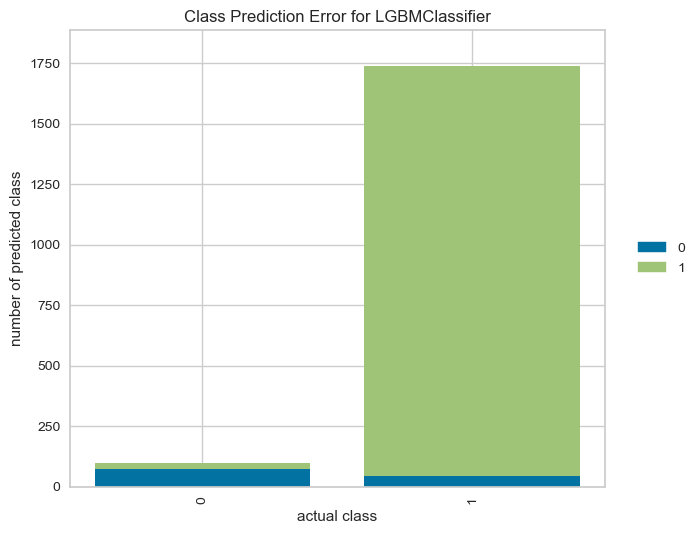

In [42]:
unbalanced_exp.plot_model(best_unbalanced_model, plot='error')

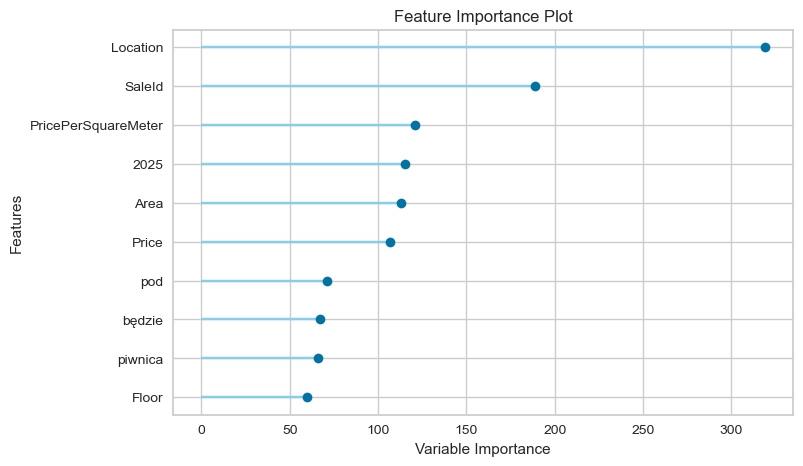

In [43]:
unbalanced_exp.plot_model(best_unbalanced_model, plot='feature')

In [44]:
tuned_model = unbalanced_exp.tune_model(best_unbalanced_model, n_iter=3, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9674,0.9520,0.9674,0.9666,0.9634,0.6796,0.7068
1,0.9673,0.9464,0.9673,0.9651,0.9654,0.7029,0.7087
2,0.9626,0.9837,0.9626,0.9615,0.9620,0.6838,0.6843
3,0.9650,0.9387,0.9650,0.9623,0.9618,0.6630,0.6770
4,0.9486,0.9488,0.9486,0.9410,0.9420,0.4750,0.4958
5,0.9626,0.9514,0.9626,0.9595,0.9588,0.6334,0.6507
6,0.9720,0.9428,0.9720,0.9706,0.9698,0.7356,0.7473
7,0.9626,0.9174,0.9626,0.9605,0.9613,0.6725,0.6748
8,0.9603,0.9664,0.9603,0.9569,0.9576,0.6325,0.6398


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [45]:
best_model = unbalanced_exp.compare_models([best_unbalanced_model, tuned_model])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.9643,0.9102,0.9643,0.9614,0.9612,0.6604,0.6730,0.2920
1,Light Gradient Boosting Machine,0.9643,0.9102,0.9643,0.9614,0.9612,0.6604,0.6730,0.2910


In [46]:
unbalanced_exp.predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9635,0.9214,0.9635,0.9610,0.9617,0.6749,0.6791


,SaleId,Title,Area,Price,PricePerSquareMeter,NumberOfRooms,BuiltYear,Type,BuildingType,Floor,...,łazienek,łazienka,łazienki,ściany,świetna,że,życia,BuildingCondition,prediction_label,prediction_score
6473,4411872,"3 pokoje, kuchnia+jadalnia Os. Strusia ENG",57.369999,620000.0,10807.040039,3.0,NaT,Mieszkania,Blok,1.0,...,0,0,2,0,1,1,0,GOOD,GOOD,1.0000
1403,4276427,Nowoczesny apartament w Łodzi Polesie,54.139999,560000.0,10343.549805,3.0,2024-01-01,Mieszkania,Blok,1.0,...,0,1,0,0,0,1,0,GOOD,GOOD,0.9705
3114,4324175,"Mieszkanie, ul. Rumiankowa",32.000000,370000.0,11562.500000,2.0,1986-01-01,Mieszkania,Blok,0.0,...,0,1,0,0,0,0,0,GOOD,GOOD,1.0000
6703,4416232,"Mieszkanie, Kielce, 82 m²",82.349998,757620.0,9200.000000,4.0,2027-01-01,Mieszkania,Blok,2.0,...,1,0,1,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,0.9999
1597,4281366,OBNIŻKA 3 pokoje 64 m2 Kraków Os. Oświecenia,63.750000,629000.0,10180.389648,3.0,NaT,Mieszkania,Blok,4.0,...,0,0,1,0,0,2,0,GOOD,GOOD,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,4408709,"Mieszkanie, ul. Lwowska",48.000000,489000.0,10187.500000,2.0,NaT,Mieszkania,Pozostałe,1.0,...,0,0,1,0,0,0,0,GOOD,GOOD,0.9996
2616,4309167,"3 Pokojowe, 46 m2, ul. Meissnera , Widokowe, Xp.",46.000000,679000.0,14760.870117,3.0,1976-01-01,Mieszkania,Blok,10.0,...,0,1,0,0,0,1,0,GOOD,GOOD,1.0000
6749,4416446,"Mieszkanie, Kielce, 37 m²",37.150002,427225.0,11500.000000,2.0,2027-01-01,Mieszkania,Blok,7.0,...,1,0,1,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,1.0000
428,4249232,"Mieszkanie, ul. Sieradzka",60.000000,520000.0,8666.669922,3.0,1980-01-01,Mieszkania,Blok,3.0,...,0,0,1,0,0,0,0,GOOD,GOOD,0.9997


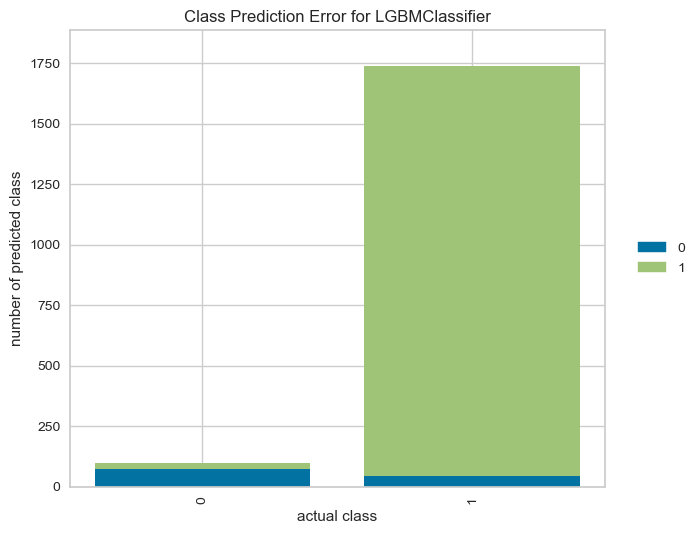

In [47]:
unbalanced_exp.plot_model(best_model, plot='error')

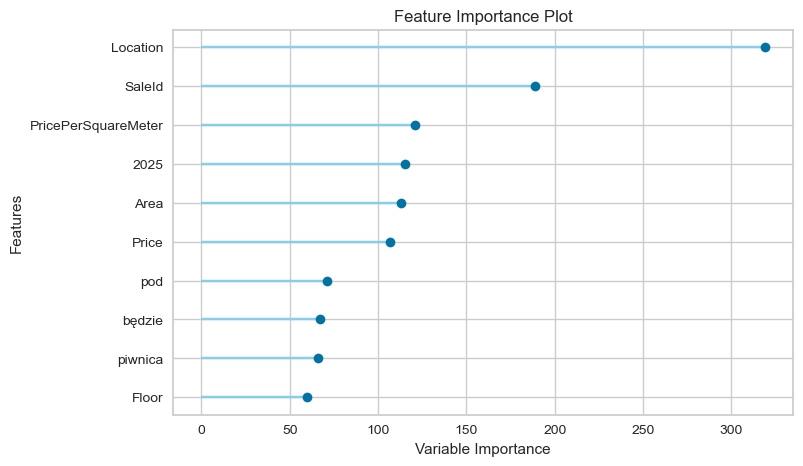

In [48]:
unbalanced_exp.plot_model(best_model, plot='feature')

In [49]:
best_tuned_model = unbalanced_exp.tune_model(
    best_model,
    optimize="F1",
    choose_better=True,
    fold=5,
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9673,0.9352,0.9673,0.9652,0.9644,0.6917,0.7057
1,0.9603,0.9557,0.9603,0.9565,0.9567,0.6181,0.6311
2,0.9556,0.9477,0.9556,0.9506,0.9511,0.5647,0.5801
3,0.9626,0.9371,0.9626,0.9595,0.9588,0.6334,0.6507
4,0.9626,0.9658,0.9626,0.9597,0.9602,0.6606,0.6680
Mean,0.9617,0.9483,0.9617,0.9583,0.9582,0.6337,0.6471
Std,0.0038,0.0115,0.0038,0.0048,0.0044,0.0426,0.0415


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [50]:
unbalanced_exp.predict_model(best_tuned_model).head(10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9635,0.9214,0.9635,0.9610,0.9617,0.6749,0.6791


,SaleId,Title,Area,Price,PricePerSquareMeter,NumberOfRooms,BuiltYear,Type,BuildingType,Floor,...,łazienek,łazienka,łazienki,ściany,świetna,że,życia,BuildingCondition,prediction_label,prediction_score
6473,4411872,"3 pokoje, kuchnia+jadalnia Os. Strusia ENG",57.369999,620000.0,10807.040039,3.0,NaT,Mieszkania,Blok,1.0,...,0,0,2,0,1,1,0,GOOD,GOOD,1.0000
1403,4276427,Nowoczesny apartament w Łodzi Polesie,54.139999,560000.0,10343.549805,3.0,2024-01-01,Mieszkania,Blok,1.0,...,0,1,0,0,0,1,0,GOOD,GOOD,0.9705
3114,4324175,"Mieszkanie, ul. Rumiankowa",32.000000,370000.0,11562.500000,2.0,1986-01-01,Mieszkania,Blok,0.0,...,0,1,0,0,0,0,0,GOOD,GOOD,1.0000
6703,4416232,"Mieszkanie, Kielce, 82 m²",82.349998,757620.0,9200.000000,4.0,2027-01-01,Mieszkania,Blok,2.0,...,1,0,1,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,0.9999
1597,4281366,OBNIŻKA 3 pokoje 64 m2 Kraków Os. Oświecenia,63.750000,629000.0,10180.389648,3.0,NaT,Mieszkania,Blok,4.0,...,0,0,1,0,0,2,0,GOOD,GOOD,1.0000
52,4238305,Mieszkanie 2 pokoje Kosmonautów,38.099998,415000.0,10892.389648,2.0,NaT,Mieszkania,Blok,10.0,...,0,0,2,0,2,0,0,GOOD,GOOD,0.9999
3909,4350889,"Mieszkanie, ul. Maciusia",44.910000,670000.0,14918.730469,3.0,1968-01-01,Mieszkania,Blok,4.0,...,0,1,0,0,0,0,0,GOOD,GOOD,0.9995
2861,4316595,"Mieszkanie, Gdynia, Chylonia, 46 m²",46.360001,435000.0,9383.089844,2.0,1980-01-01,Mieszkania,NaN,0.0,...,0,1,0,0,0,0,0,GOOD,GOOD,1.0000
6571,4414008,"2-pok, ul. Bronowicka, super lokalizacja, wygodne",53.470001,848000.0,15859.360352,2.0,2005-01-01,Mieszkania,NaN,1.0,...,1,1,6,4,0,0,0,GOOD,GOOD,1.0000
4503,4365929,Mieszkanie,44.599998,579000.0,12982.059570,2.0,2004-01-01,Mieszkania,Blok,3.0,...,0,0,1,0,0,0,0,GOOD,GOOD,0.9999


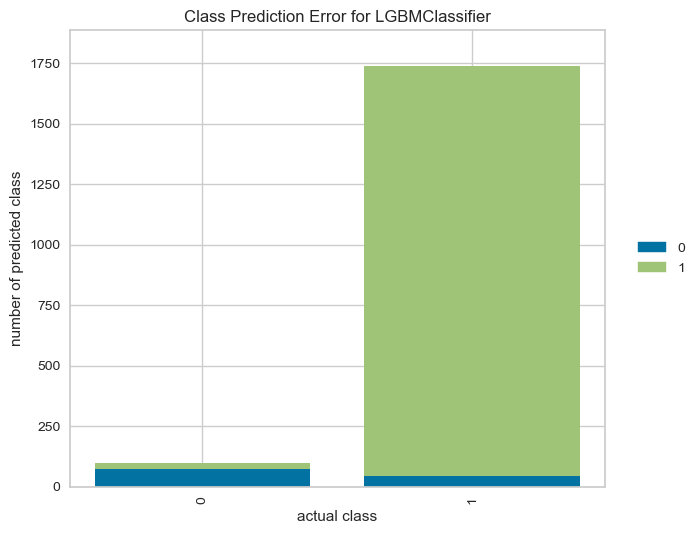

In [51]:
unbalanced_exp.plot_model(best_tuned_model, plot='error')

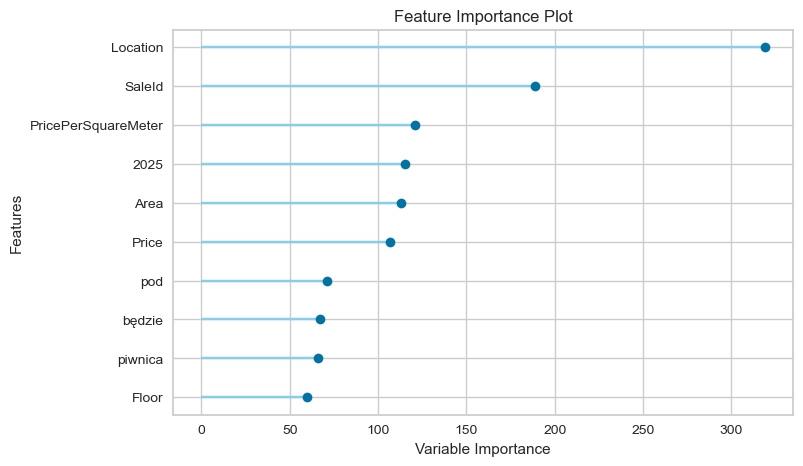

In [52]:
unbalanced_exp.plot_model(best_tuned_model, plot='feature')

In [53]:
best_final_model = unbalanced_exp.finalize_model(best_tuned_model)
best_final_model

Pipeline(memory=Memory(location=None),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['BuiltYear'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=Non...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                random_state=1123, reg_alpha=0.0,
                                reg_lambda=0.0, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

In [55]:
unbalanced_exp.save_model(best_final_model, "model_GOOD", verbose=False);

In [56]:
unbalanced_exp.predict_model(best_final_model).head(10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9711,0.9423,0.9711,0.9700,0.9704,0.7532,0.7546


,SaleId,Title,Area,Price,PricePerSquareMeter,NumberOfRooms,BuiltYear,Type,BuildingType,Floor,...,łazienek,łazienka,łazienki,ściany,świetna,że,życia,BuildingCondition,prediction_label,prediction_score
6473,4411872,"3 pokoje, kuchnia+jadalnia Os. Strusia ENG",57.369999,620000.0,10807.040039,3.0,NaT,Mieszkania,Blok,1.0,...,0,0,2,0,1,1,0,GOOD,GOOD,1.0000
1403,4276427,Nowoczesny apartament w Łodzi Polesie,54.139999,560000.0,10343.549805,3.0,2024-01-01,Mieszkania,Blok,1.0,...,0,1,0,0,0,1,0,GOOD,GOOD,0.9797
3114,4324175,"Mieszkanie, ul. Rumiankowa",32.000000,370000.0,11562.500000,2.0,1986-01-01,Mieszkania,Blok,0.0,...,0,1,0,0,0,0,0,GOOD,GOOD,1.0000
6703,4416232,"Mieszkanie, Kielce, 82 m²",82.349998,757620.0,9200.000000,4.0,2027-01-01,Mieszkania,Blok,2.0,...,1,0,1,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,0.9999
1597,4281366,OBNIŻKA 3 pokoje 64 m2 Kraków Os. Oświecenia,63.750000,629000.0,10180.389648,3.0,NaT,Mieszkania,Blok,4.0,...,0,0,1,0,0,2,0,GOOD,GOOD,1.0000
52,4238305,Mieszkanie 2 pokoje Kosmonautów,38.099998,415000.0,10892.389648,2.0,NaT,Mieszkania,Blok,10.0,...,0,0,2,0,2,0,0,GOOD,GOOD,0.9999
3909,4350889,"Mieszkanie, ul. Maciusia",44.910000,670000.0,14918.730469,3.0,1968-01-01,Mieszkania,Blok,4.0,...,0,1,0,0,0,0,0,GOOD,GOOD,0.9998
2861,4316595,"Mieszkanie, Gdynia, Chylonia, 46 m²",46.360001,435000.0,9383.089844,2.0,1980-01-01,Mieszkania,NaN,0.0,...,0,1,0,0,0,0,0,GOOD,GOOD,1.0000
6571,4414008,"2-pok, ul. Bronowicka, super lokalizacja, wygodne",53.470001,848000.0,15859.360352,2.0,2005-01-01,Mieszkania,NaN,1.0,...,1,1,6,4,0,0,0,GOOD,GOOD,1.0000
4503,4365929,Mieszkanie,44.599998,579000.0,12982.059570,2.0,2004-01-01,Mieszkania,Blok,3.0,...,0,0,1,0,0,0,0,GOOD,GOOD,0.9995


In [ ]:
predictions = unbalanced_exp.predict_model(best_final_model)

In [ ]:
plot_model(best_final_model, plot="auc")

In [ ]:
plot_model(best_final_model, plot="confusion_matrix")
# ile wartości z oryginalnego zbioru danych (True Class) algorytm zmienił na nową wartość po analizie(Predicted Class)
# np. 7 wartości oryginalnych o ocenie 1 zostało zmienionych na 0

## Confusion Matrix (Macierz pomyłek)

Confusion Matrix to tabela, która przedstawia liczbę poprawnych i niepoprawnych klasyfikacji dla każdej klasy. Ułatwia analizę, gdzie model popełnia błędy.

|               | Predicted Positive | Predicted Negative |
|---------------|--------------------|--------------------|
| Actual Positive | True Positive (TP)  | False Negative (FN) |
| Actual Negative | False Positive (FP) | True Negative (TN)  |
 
Analiza macierzy pomyłek pozwala zrozumieć, które klasy są mylone przez model oraz jaki jest balans między różnymi rodzajami błędów.

<span style="color:red">Idealny model miałby same wartości na przekątnej (TP i TN) oraz zera poza nią.</span>

In [ ]:
plt.figure(figsize=(12, 6))
plt.barh(unbalanced_metrics_df['Model'], unbalanced_metrics_df['F1'], color='skyblue')
plt.xlabel('F1')
plt.title('Porównanie dokładności modeli wg. metryki F1')
plt.gca().invert_yaxis()  # najlepszy model na górze
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
best_final_model.get_params()

In [ ]:
predicted_column = predictions['prediction_label']
print(predicted_column)

In [ ]:
df_last=predictions[['prediction_label','BuildingCondition', ]]

In [ ]:
#df_last = df_last.reset_index()  
#print(df_last.columns) 

In [ ]:
#df_last.rename(columns={'index': 'SaleId'}, inplace=True)

In [ ]:
df_last.to_csv('2024_stan_AFTER_REN.csv')

In [ ]:
from pycaret.classification import load_model, predict_model

In [ ]:
best_final_model = load_model("model_AFTER_REN")

In [ ]:
df_last

In [ ]:
# 1. Wczytaj dane
df_raw = pd.read_csv("2024_stan_AFTER_REN.csv")

# 2. Zrób tymczasową kopię do predykcji — z placeholderami
df_predict = df_raw.copy()
df_predict["BuildingCondition"] = df_predict["BuildingCondition"].fillna(" ")

In [ ]:
df_predict['BuiltYear'] = pd.to_datetime(df_predict['BuiltYear'], format='%Y', errors='coerce')

In [ ]:
df_predict[['Title', 'Description']] = df_predict[['Title', 'Description']].fillna('')

In [ ]:
# 3. Setup z text_features (ważne!)
#exp = setup(
#    data=df_predict,
#    target='BuildingCondition',
#    session_id=1123,
#    categorical_features=['BuildingType', 'Location'],
#    text_features=['Title', 'Description'],
#    text_features_method='bow',
#    keep_features=['SaleId'],
#    date_features=['BuiltYear'],
#    ordinal_features={
#        'BuildingType': ['Pozostałe', 'Blok', 'Apartametowiec', 'Kamienica']
#    },
#    verbose=False
#)

In [ ]:
# 1. Wyciągnij kolumny, które model zna
expected_cols = best_final_model.feature_names_in_

#  Napraw BuiltYear
df_raw['BuiltYear'] = pd.to_datetime(df_raw['BuiltYear'], errors='coerce')

# 2. Funkcja dopasowująca df_raw
def align_dataframe(df_raw, expected_cols):
    # Usuń 'BuildingCondition' z listy expected_cols
    expected_cols = [col for col in expected_cols if col != 'BuildingCondition']

    # Dodaj brakujące kolumny
    for col in expected_cols:
        if col not in df_raw.columns:
            df_raw[col] = 0  # albo NaN

    # Usuń BuildingCondition jeśli jest
    if 'BuildingCondition' in df_raw.columns:
        df_raw = df_raw.drop(columns=['BuildingCondition'])
    
    # Ustaw kolejność kolumn
    df_aligned = df_raw[expected_cols]

    return df_aligned

# 3. Użycie
df_aligned = align_dataframe(df_raw, expected_cols)

# 4. Predykcja
predictions = predict_model(best_final_model, data=df_aligned)

In [ ]:
result = df_aligned.copy()
result['Prediction_State'] = predictions['prediction_label']

# 5. Wyświetl
print(result)

In [ ]:
# 1. Skopiuj oryginalne dane
final_result = df_raw.copy()

# 2. Usuń starą kolumnę BuildingCondition
if 'BuildingCondition' in final_result.columns:
    final_result = final_result.drop(columns=['BuildingCondition'])

# 3. Dodaj nową kolumnę z predykcją
final_result['Predicted_State'] = predictions['prediction_label']

# 4. Wyświetl efekt
final_result

In [ ]:
# 1. Wczytaj dane z pliku
df_raw = pd.read_csv("sale_2024_0.csv")

# 2. Dodaj kolumnę z predykcją do oryginalnego df_raw
df_raw['Predicted_State'] = predictions['prediction_label']

# 3. Wyświetl efekt
df_raw

In [ ]:
df_raw = df_raw[~((df_raw['Link'].str.contains('otodom', case=False, na=False)) & 
                              (df_raw['BuildingCondition'] == 'AFTER_RENOVATION'))]

In [ ]:
df_raw["Predicted_State"].value_counts(normalize=True)

In [ ]:
df_raw

In [ ]:
df_raw.to_csv('0_sale_2024_stan_final.csv')

In [ ]:
df1=pd.read_csv("0_sale_2024_stan_final.csv")

In [ ]:
df2=df1.sample(10)

In [ ]:
df2

In [ ]:
df2.to_csv('01_sample10.csv')